In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

# LOAD DATASET

In [2]:
df_2021VAERSVAX = pd.read_csv('C:\\Users\\User\\Downloads\\archive\\2021VAERSVAX.csv')
#This table provide the remaining vaccine information for each of the vaccines listed, which could be multiple

df_2021VAERSSYMPTOMS = pd.read_csv('C:\\Users\\User\\Downloads\\archive\\2021VAERSSYMPTOMS.csv')
#Provides the adverse event coded terms 

df_2021VAERSDATA = pd.read_csv('C:\\Users\\User\\Downloads\\archive\\2021VAERSDATA.csv', encoding='ISO-8859-1')


C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7,12,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# CLEAN DATASET BY REMOVING NON-ESSENTIAL COLUMN AND FILL THE NAN VALUE WITH SOME NECESSARY KEYWORD RELEVANT TO OUR DESIRE 

In [3]:
df_2021VAERSSYMPTOMS_clean = df_2021VAERSSYMPTOMS.drop(columns=["SYMPTOMVERSION1","SYMPTOMVERSION2", "SYMPTOMVERSION3", "SYMPTOMVERSION4", "SYMPTOMVERSION5"]).set_index("VAERS_ID").unstack().dropna().reset_index(name='SYMPTOMS')[["VAERS_ID", "SYMPTOMS"]].groupby("VAERS_ID").agg(lambda x: list(x))

df_2021VAERSDATA_clean = df_2021VAERSDATA.drop(columns=["CAGE_YR", "CAGE_MO", "ER_VISIT", "RPT_DATE", "NUMDAYS", "V_FUNDBY", "FORM_VERS","SYMPTOM_TEXT","DATEDIED","LAB_DATA",'SPLTTYPE','BIRTH_DEFECT','TODAYS_DATE','X_STAY']).fillna(value={'DIED': 'N', "RECOVD": 'U','DISABLE':'N',"OTHER_MEDS":'N',"L_THREAT":'N','HOSPITAL':0,"PRIOR_VAX":'N','ER_ED_VISIT':'N','OFC_VISIT':"N",'HOSPDAYS':0}).astype({'SEX': 'category', "RECOVD": 'category', "V_ADMINBY": 'category'})

df_2021VAERSVAX_clean = df_2021VAERSVAX[df_2021VAERSVAX["VAX_TYPE"]=="COVID19"].drop(columns=['VAX_LOT'])


# MERGE ALL THE DATA FRAMES IRRESPECTIVE OF VAERS ID

In [4]:
df_cleaned = (
    df_2021VAERSDATA_clean.merge(df_2021VAERSVAX_clean, how="inner", left_on="VAERS_ID", right_on="VAERS_ID")
    .merge(df_2021VAERSSYMPTOMS_clean, how="left", left_on="VAERS_ID", right_on="VAERS_ID")
             )

# CLEAN THE DUPLICATE AND MULTIPLE VALUE OF SAME VAERS ID

In [5]:
index =df_cleaned['VAERS_ID']
is_duplicate = index.duplicated(keep="first")
not_duplicate = ~is_duplicate
df_cleaned = df_cleaned[not_duplicate]

# EXTRACTING SYMPTOMS FROM THE SYMPTOMS LIST AND COUNT THE FREQUENCY OF ITS TYPE 

In [6]:
SYMP_LIST = df_cleaned["SYMPTOMS"].explode().unique()
a = pd.Series([item for sublist in df_cleaned.SYMPTOMS for item in sublist])
new_df_for_symp_count = a.value_counts().sort_index().rename_axis('SYMPTOM').reset_index(name='frequency')
#df.sort_values("frequency", ascending=False)
new_df_for_symp_count = new_df_for_symp_count

.sort_values(by=['frequency'],ascending=False)
new_df_for_symp_count

,SYMPTOM,frequency
1776,Headache,7240
3159,Pyrexia,5827
934,Chills,5518
1513,Fatigue,5237
2804,Pain,4802
2615,Nausea,4156
1247,Dizziness,3470
2806,Pain in extremity,3092
2561,Myalgia,2879
2094,Injection site pain,2775


# REPLACE ALL KINDS OF  PAIN(such as back pain, neck pain,chest pain) TO PAIN

In [7]:
Pain_List = ['Back pain','Neck pain','Oropharyngeal pain','Ear pain','Eye pain','Abdominal pain','Axillary pain','Lymph node pain','Pain in jaw','Bone pain','Pain of skin','Facial pain','Breast pain','Flank pain','Musculoskeletal chest pain','Vaccination site pain']

def f(replaced_value, col1):
    def r(s):
        while replaced_value in s[col1]:
            s[col1][s[col1].index(replaced_value)] = 'Pain'
        return s
    return r
for item in Pain_List:
    df_cleaned= df_cleaned.apply(f(item,"SYMPTOMS"), axis=1)



# REPLACE ALL KINDS OF COMPUTERISED TOMOGRAM TEST  TO COMPUTERISED TOMOGRAM TEST

In [8]:
Tomogram_List = ['Computerised tomogram coronary artery normal','Computerised tomogram coronary artery','Computerised tomogram aorta','Computerised tomogram pancreas normal','Computerised tomogram intestine',
'Computerised tomogram abdomen normal',
'Computerised tomogram pelvis',
'Computerised tomogram pelvis abnormal',
'Computerised tomogram spine',
'Computerised tomogram neck',
'Computerised tomogram thorax normal',
'Computerised tomogram abdomen abnormal',
'Computerised tomogram thorax abnormal',
'Computerised tomogram head abnormal',
'Computerised tomogram abdomen',
'Computerised tomogram thorax',
'Computerised tomogram abnormal',
'Computerised tomogram normal',
'Computerised tomogram head normal',
'Computerised tomogram head',
'Computerised tomogram' 
                
                ]

def f(replaced_value, col1):
    def r(s):
        while replaced_value in s[col1]:
            s[col1][s[col1].index(replaced_value)] = 'Tomogram Test'
        return s
    return r
for item in Tomogram_List:
    df_cleaned= df_cleaned.apply(f(item,"SYMPTOMS"), axis=1)

In [9]:
MRI_List = [
'Magnetic resonance imaging',
'Magnetic resonance imaging brain',
'Magnetic resonance imaging brain abnormal',
'Magnetic resonance imaging normal',
'Magnetic resonance imaging brain normal',
'Magnetic resonance imaging abnormal',
'Magnetic resonance imaging head',
'Magnetic resonance imaging neck',
'Magnetic resonance imaging spinal abnormal',
'Magnetic resonance imaging spinal',
'Magnetic resonance imaging heart',
'Magnetic resonance imaging head abnormal',
'Magnetic resonance imaging head normal',
'Magnetic resonance imaging thoracic abnormal',               
                ]

def f(replaced_value, col1):
    def r(s):
        while replaced_value in s[col1]:
            s[col1][s[col1].index(replaced_value)] = 'MRI Test'
        return s
    return r
for item in MRI_List:
    df_cleaned= df_cleaned.apply(f(item,"SYMPTOMS"), axis=1)

In [10]:
Xray_List = [
    'X-ray',
'X-ray normal',
'X-ray limb',
'X-ray abnormal',
'X-ray limb normal',
'Spinal X-ray',
'X-ray of pelvis and hip',
'Abdominal X-ray ',
'X-ray of pelvis and hip abnormal ',
'X-ray limb abnormal',
'X-ray with contrast', 
'Spinal X-ray normal ',
'Urinary system x-ray abnormal',
'Urinary system X-ray',
'Spinal X-ray abnormal',
'X-ray of pelvis and hip normal',
'X-ray with contrast lower gastrointestinal tract',
'X-ray with contrast upper gastrointestinal tra...'
                
                ]

def f(replaced_value, col1):
    def r(s):
        while replaced_value in s[col1]:
            s[col1][s[col1].index(replaced_value)] = 'Xray Test'
        return s
    return r
for item in Xray_List:
    df_cleaned= df_cleaned.apply(f(item,"SYMPTOMS"), axis=1)

# REPLACE ALL KINDS OF CHEST RELATED AILMENTS TO CHEST PROBLEM

In [11]:
Chest_List = ['Chest pain','Chest X-ray','Chest X-ray abnormal','Chest discomfort']

def f(replaced_value, col1):
    def r(s):
        while replaced_value in s[col1]:
            s[col1][s[col1].index(replaced_value)] = 'Chest Problem'
        return s
    return r
for item in Chest_List:
    df_cleaned= df_cleaned.apply(f(item,"SYMPTOMS"), axis=1)


# REPLACE ALL KINDS OF HEADACHE(such as Tension headache','Sinus headache','Cluster headache','Thunderclap headache') TO HEADACHE

In [12]:
Headache_List = ['Tension headache','Sinus headache','Cluster headache','Thunderclap headache','Exertional headache','Primary headache associated with sexual activity']

def f(replaced_value, col1):
    def r(s):
        while replaced_value in s[col1]:
            s[col1][s[col1].index(replaced_value)] = 'Headache'
        return s
    return r
for item in Headache_List:
    df_cleaned= df_cleaned.apply(f(item,"SYMPTOMS"), axis=1)

# REPLACE ALL KINDS OF PNEUMONIA TO  PNEUMONIA

In [13]:
PNEUMONIA_List = ['COVID-19 pneumonia']

def f(replaced_value, col1):
    def r(s):
        while replaced_value in s[col1]:
            s[col1][s[col1].index(replaced_value)] = 'PNEUMONIA'
        return s
    return r
for item in PNEUMONIA_List:
    df_cleaned= df_cleaned.apply(f(item,"SYMPTOMS"), axis=1)

# REPLACE ALL KINDS OF  INJECTION SITE AILMENTS(such as injection site pain,injection site swelling ) TO INJECTION SITE REACTION¶

In [14]:
Injection_site_List = ['Injection site pain',
'Injection site erythema',
'Injection site swelling',
'Injection site pruritus',
'Injection site swelling',
'Injection site pruritus',
'Injection site warmth',
'Injection site rash',
'Injection site induration',
'Injection site reaction',
'Injection site urticaria',
'Injection site mass',
'Injection site bruising',
'Injection site nodule',
'Injection site cellulitis',
'Injection site discomfort',
'Injection site inflammation',
'Injection site hypoaesthesia',
'Injection site discolouration',
'Injection site paraesthesia',
'Injection site oedema',
'Injection site vesicles',
'Injection site irritation',
'Injection site haemorrhage',
'Injection site streaking',
'Injection site lymphadenopathy',
'Injection site joint pain',
'Injection site hypersensitivity',
'Injection site extravasation',
'Injection site muscle weakness',
'Injection site movement impairment',
'Injection site infection',
'Injection site scab',
'Injection site abscess',
    
]

def f(replaced_value, col1):
    def r(s):
        while replaced_value in s[col1]:
            s[col1][s[col1].index(replaced_value)] = 'Injection Site Reaction'
        return s
    return r
for item in Injection_site_List:
    df_cleaned= df_cleaned.apply(f(item,"SYMPTOMS"), axis=1)


# REPLACE ALL KINDS  OF Dyspnoea to Dyspnoea

In [15]:
Dyspnoea_List = [
                'Dyspnoea exertional',
                'Dyspnoea at rest',
                'Dyspnoea paroxysmal nocturnal'
                ]

def f(replaced_value, col1):
    def r(s):
        while replaced_value in s[col1]:
            s[col1][s[col1].index(replaced_value)] = 'Dyspnoea'
        return s
    return r
for item in Dyspnoea_List:
    df_cleaned= df_cleaned.apply(f(item,"SYMPTOMS"), axis=1)



# HANDLE THE COVID POSITIVE 

In [16]:
Covid_Positive_List = [
                'SARS-CoV-2 test',
                'SARS-CoV-2 test positive','COVID-19','Exposure to SARS-CoV-2'
                   
    
    
                ]

def f(replaced_value, col1):
    def r(s):
        while replaced_value in s[col1]:
            s[col1][s[col1].index(replaced_value)] = 'COVID-19 POSITIVE'
        return s
    return r
for item in Covid_Positive_List :
    df_cleaned= df_cleaned.apply(f(item,"SYMPTOMS"), axis=1)

# REPLACE ALL KINDS OF ASTHENIA TO ASTHENIA

In [17]:
Asthenia_List = [
                'Myasthenia gravis',
                 'Myasthenia gravis crisis',
                ]

def f(replaced_value, col1):
    def r(s):
        while replaced_value in s[col1]:
            s[col1][s[col1].index(replaced_value)] = 'Asthenia'
        return s
    return r
for item in Asthenia_List:
    df_cleaned= df_cleaned.apply(f(item,"SYMPTOMS"), axis=1)

# REPLACE ALL KINDS OF DEATH VALUE TO DEATH

In [18]:
Death_List = [
                'Sudden death'          
]

def f(replaced_value, col1):
    def r(s):
        while replaced_value in s[col1]:
            s[col1][s[col1].index(replaced_value)] = 'Death'
        return s
    return r
for item in Death_List:
    df_cleaned= df_cleaned.apply(f(item,"SYMPTOMS"), axis=1)


# REPLACE ALL KINDS OF  DIARRHOEA TO DIARRHOEA

In [19]:
Diarrhoea_List = [
                'Diarrhoea haemorrhagic'          
]

def f(replaced_value, col1):
    def r(s):
        while replaced_value in s[col1]:
            s[col1][s[col1].index(replaced_value)] = 'Diarrhoea'
        return s
    return r
for item in Diarrhoea_List:
    df_cleaned= df_cleaned.apply(f(item,"SYMPTOMS"), axis=1)


# REPLACE ALL KINDS OF HYPOAESTHESIA TO HYPOAESTHESIA

In [20]:
Hypoaesthesia_List = [
                'Hypoaesthesia oral',
    'Pharyngeal hypoaesthesia',
    'Hypoaesthesia eye',
    'Vaccination site hypoaesthesia',
    'Intranasal hypoaesthesia',
    'Genital hypoaesthesia',
    'Hypoaesthesia teeth'
]

def f(replaced_value, col1):
    def r(s):
        while replaced_value in s[col1]:
            s[col1][s[col1].index(replaced_value)] = 'Hypoaesthesia'
        return s
    return r
for item in Hypoaesthesia_List:
    df_cleaned= df_cleaned.apply(f(item,"SYMPTOMS"), axis=1)

# REPLACE ALL KINDS OF RASH TO RASH

In [21]:
Rash_List = [
                'Rash erythematous',
    'Rash pruritic',
    'Rash macular',
    'Rash papular',
    'Rash vesicular',
    'Vaccination site rash',
    'Rash maculo-papular',
    'Rash pustular'
    
]

def f(replaced_value, col1):
    def r(s):
        while replaced_value in s[col1]:
            s[col1][s[col1].index(replaced_value)] = 'Rash'
        return s
    return r
for item in Rash_List:
    df_cleaned= df_cleaned.apply(f(item,"SYMPTOMS"), axis=1)



# REPLACE ALL KINDS OF COUGH TO COUGH

In [22]:
Cough_List = [
                'Productive cough',
    'Upper-airway cough syndrome',
    'Cough variant asthma',
    
]

def f(replaced_value, col1):
    def r(s):
        while replaced_value in s[col1]:
            s[col1][s[col1].index(replaced_value)] = 'Cough'
        return s
    return r
for item in Cough_List:
    df_cleaned= df_cleaned.apply(f(item,"SYMPTOMS"), axis=1)



# REPLACE ALL KINDS OF SWELLING TO SWELLING

In [23]:
Swelling_List = [
               'Bone swelling',
'Auricular swelling',
'Peripheral swelling',
'Swelling face',
'Lip swelling',
'Pharyngeal swelling',
'Vaccination site swelling',
'Eye swelling',
'Joint swelling',
'Periorbital swelling',
'Swelling of eyelid',
'Mouth swelling',
'Skin swelling',
'Ear swelling',
'Gingival swelling',
'Muscle swelling',
'Palatal swelling',
'Circumoral swelling',
'Soft tissue swelling',

    
]

def f(replaced_value, col1):
    def r(s):
        while replaced_value in s[col1]:
            s[col1][s[col1].index(replaced_value)] = 'Swelling'
        return s
    return r
for item in Swelling_List:
    df_cleaned= df_cleaned.apply(f(item,"SYMPTOMS"), axis=1)



# NEW FREQUENCY TABLE OF SYMPTOMS

In [24]:
SYMP_LIST = df_cleaned["SYMPTOMS"].explode().unique()
a = pd.Series([item for sublist in df_cleaned.SYMPTOMS for item in sublist])
new_df_for_symp_count = a.value_counts().sort_index().rename_axis('SYMPTOM').reset_index(name='frequency')
#df.sort_values("frequency", ascending=False)
new_df_for_symp_count = new_df_for_symp_count.sort_values(by=['frequency'],ascending=False)
new_df_for_symp_count = new_df_for_symp_count.nlargest(200, ['frequency'])
new_df_for_symp_count

,SYMPTOM,frequency
2006,Injection Site Reaction,11574
2698,Pain,8869
1727,Headache,7281
3044,Pyrexia,5827
923,Chills,5518
1467,Fatigue,5237
2510,Nausea,4156
1211,Dizziness,3470
743,COVID-19 POSITIVE,3331
2700,Pain in extremity,3092


# LIST THE TOP ALL AILMENTS (RESULT OF C-19 VACCINE REACTION)

In [25]:
Reaction_List = [x.upper() for x in new_df_for_symp_count['SYMPTOM']]

# CONVERT ALL THE CHARACTER TO UPPER CASE OF SYMPTOMS COLUMN

In [26]:
df_cleaned["SYMPTOMS"] = df_cleaned["SYMPTOMS"].astype(str)
df_cleaned["SYMPTOMS"]  = df_cleaned["SYMPTOMS"].str.upper()

# CREATION OF COLUMN OF THE REACTIONS OF C-19 VACCINE IN THE DATA SET

In [27]:
for item in Reaction_List:
    df_cleaned[item] = (df_cleaned.apply(lambda x: x.astype(str).str.contains(item)).any(axis=1).astype(int))

# HANDLE THE DIED AND DEATH COLUMN

In [28]:
df_cleaned["DIED"].replace({"Y": 1, "N": 0}, inplace=True)

In [29]:
dead_died_handle_list =['DEATH','DIED']
index_list =[]
for col in dead_died_handle_list:
    index_names = df_cleaned[ df_cleaned[col] == 1].index
    print (" ",col," ",len(index_names))
    index_list.append(index_names)
flat_index_list = [item for sublist in index_list for item in sublist]
flat_index_set = set(flat_index_list)
flat_index_list = list(flat_index_set)

  DEATH   1682
  DIED   1904


In [30]:
df_cleaned.loc[flat_index_list,'DEATH'] = 1
df_cleaned.loc[flat_index_list,'DIED'] = 1

In [31]:
df_cleaned = df_cleaned.drop(columns=['DEATH'])

# HANDLE HOSPITALIZED

In [32]:
df_cleaned['HOSPITAL'] = df_cleaned["HOSPITAL"] .replace(['Y'], 1)
df_cleaned['HOSPITAL'] = df_cleaned['HOSPITAL'].astype(int)
df_cleaned['HOSPDAYS'] = df_cleaned['HOSPDAYS'].astype(int)

# HANDLE HOSPITAL DAYS

In [33]:
HOS_handle_list =['HOSPDAYS','HOSPITAL']
index_list =[]
for col in HOS_handle_list:
    index_names = df_cleaned[ df_cleaned[col] != 0].index
    print (" ",col," ",len(index_names))
    index_list.append(index_names)
flat_index_list = [item for sublist in index_list for item in sublist]
flat_index_set = set(flat_index_list)
flat_index_list = list(flat_index_set)


  HOSPDAYS   2824
  HOSPITAL   4294


In [34]:
df_cleaned.loc[flat_index_list,'HOSPITAL'] = 1
    

In [35]:
df_cleaned.isnull().sum()

VAERS_ID                                                    0
RECVDATE                                                    0
STATE                                                    5498
AGE_YRS                                                  3036
SEX                                                         0
DIED                                                        0
L_THREAT                                                    0
HOSPITAL                                                    0
HOSPDAYS                                                    0
DISABLE                                                     0
RECOVD                                                      0
VAX_DATE                                                 1392
ONSET_DATE                                               1722
V_ADMINBY                                                   0
OTHER_MEDS                                                  0
CUR_ILL                                                 17839
HISTORY 

In [36]:
df_cleaned = df_cleaned.drop(columns=['HOSPDAYS',])

In [37]:
df_cleaned = df_cleaned.drop(columns=['VAERS_ID','RECVDATE','STATE','AGE_YRS','SEX','L_THREAT','VAX_DATE','ONSET_DATE','SYMPTOMS','VAX_NAME','VAX_SITE','VAX_ROUTE','VAX_DOSE_SERIES','VAX_MANU','VAX_TYPE','ALLERGIES','ER_ED_VISIT','OFC_VISIT','PRIOR_VAX','HISTORY','CUR_ILL','OTHER_MEDS','V_ADMINBY','RECOVD','DISABLE'])

In [38]:
df_cleaned.isnull().sum()

DIED                                                    0
HOSPITAL                                                0
INJECTION SITE REACTION                                 0
PAIN                                                    0
HEADACHE                                                0
PYREXIA                                                 0
CHILLS                                                  0
FATIGUE                                                 0
NAUSEA                                                  0
DIZZINESS                                               0
COVID-19 POSITIVE                                       0
PAIN IN EXTREMITY                                       0
SWELLING                                                0
RASH                                                    0
MYALGIA                                                 0
DYSPNOEA                                                0
ARTHRALGIA                                              0
CHEST PROBLEM 

# CREATE A DATA FRAME CONTAINING ONLY VACCINE REACTION WITH TARGET VALUE

In [39]:
new_df = df_cleaned.copy()


In [40]:
new_df.to_csv('feature_selection2.csv', encoding='utf-8')

In [41]:
new_df.columns

Index(['DIED', 'HOSPITAL', 'INJECTION SITE REACTION', 'PAIN', 'HEADACHE',
       'PYREXIA', 'CHILLS', 'FATIGUE', 'NAUSEA', 'DIZZINESS',
       ...
       'HEMIPARESIS', 'EPISTAXIS', 'INVESTIGATION', 'INFLAMMATION',
       'THROMBOSIS', 'ULTRASOUND SCAN', 'DEEP VEIN THROMBOSIS',
       'PHARYNGEAL PARAESTHESIA', 'SEPSIS', 'EAR DISCOMFORT'],
      dtype='object', length=200)

In [42]:
x =  new_df.drop(columns=['HOSPITAL','DIED','COVID-19 POSITIVE'])

In [1]:
y = new_df['DIED']
y1 = new_df['HOSPITAL']
y2 = new_df['COVID-19 POSITIVE']

NameError: name 'new_df' is not defined

[2.44878569e-02 2.07164493e-02 1.80706360e-02 1.37712048e-02
 1.14795266e-02 1.11790403e-02 1.04798707e-02 1.59765880e-02
 4.83653013e-03 8.62502906e-03 1.10098307e-02 8.15742484e-03
 1.73428263e-02 5.31948747e-03 1.11385529e-02 7.64395879e-03
 1.09467970e-02 1.27455835e-02 5.68386583e-03 9.27380566e-03
 4.60804076e-03 1.20872516e-02 8.32207857e-03 7.16441082e-03
 5.63316717e-03 7.83560985e-03 4.62485534e-03 5.01917924e-03
 5.67727605e-03 9.50697192e-03 3.45759366e-03 7.67918331e-03
 2.94811986e-03 3.15505818e-03 4.63135761e-03 2.22771947e-03
 5.56980275e-03 1.01767973e-02 8.60940183e-03 2.66249074e-03
 4.84881718e-03 8.33932256e-04 2.32421360e-03 6.63288829e-03
 8.25609553e-03 9.20589853e-04 3.52163731e-03 9.36788392e-03
 9.87207712e-03 2.46904556e-03 4.25525149e-03 3.69546512e-03
 4.13397735e-03 6.68532958e-03 1.54977837e-03 4.90714636e-03
 1.46316804e-03 4.39518469e-03 7.62497197e-03 1.11922096e-03
 1.96665287e-03 3.27306341e-03 5.80687542e-02 6.38838581e-03
 1.79763606e-03 1.312236

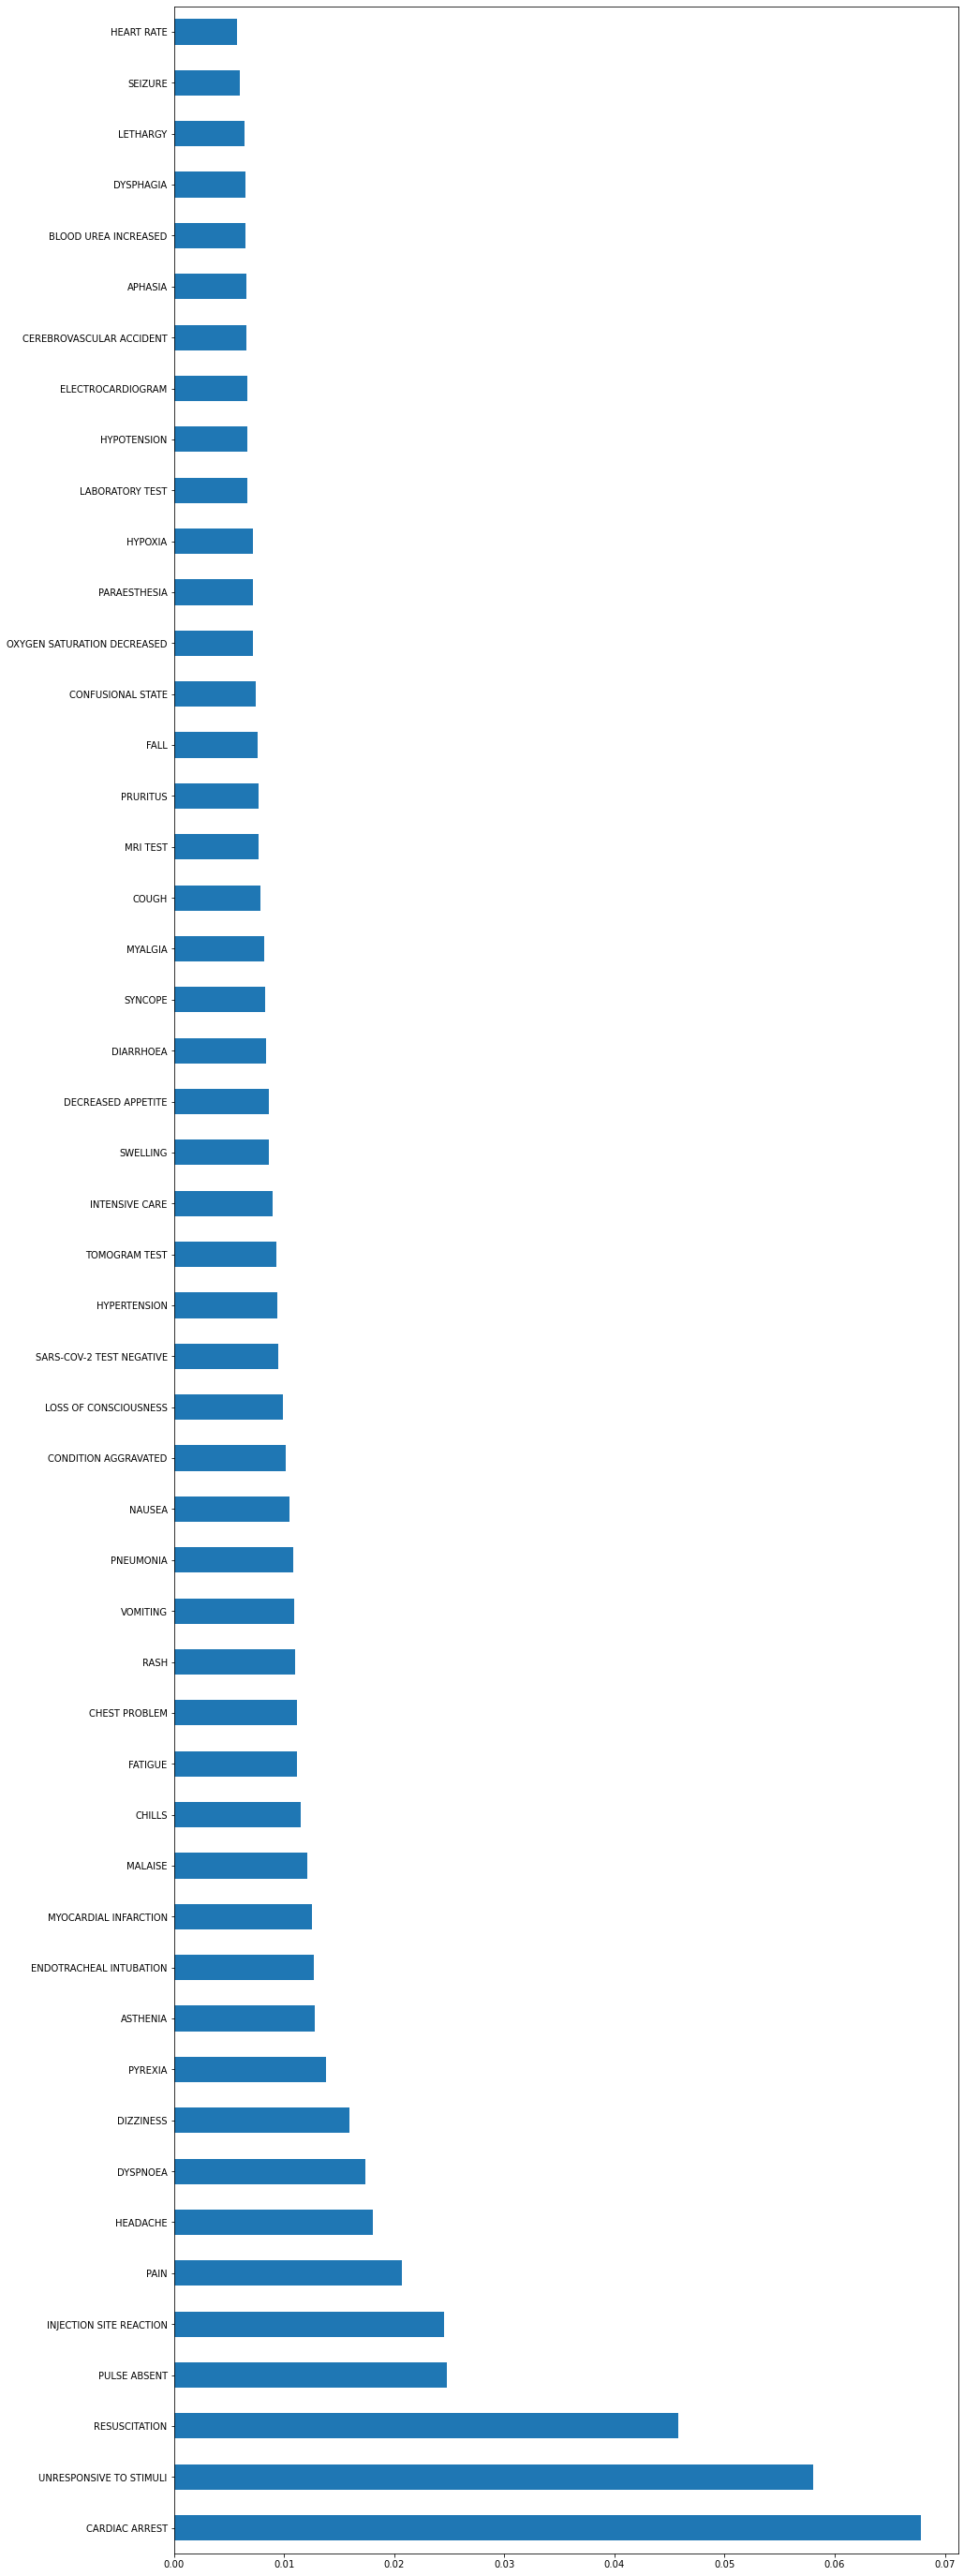

In [44]:
import pandas as pd

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,50)
model = ExtraTreesClassifier()
model.fit(x,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(50).plot(kind='barh')
plt.show()

In [60]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#apply SelectKBest class to extract top  best features scores greater than 100
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)

featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(27,'Score')) 

                           Specs        Score
107               CARDIAC ARREST  1991.380548
127                RESUSCITATION  1783.639032
62       UNRESPONSIVE TO STIMULI  1645.566816
185                 PULSE ABSENT  1030.360066
136      ENDOTRACHEAL INTUBATION   453.226582
2                       HEADACHE   346.372799
1                           PAIN   309.401004
0        INJECTION SITE REACTION   286.672017
180         BLOOD UREA INCREASED   285.814031
154        MYOCARDIAL INFARCTION   278.430207
89                     PNEUMONIA   264.944769
4                         CHILLS   250.986287
142   BLOOD CREATININE INCREASED   234.785621
128                      HYPOXIA   183.989089
101  OXYGEN SATURATION DECREASED   165.994675
3                        PYREXIA   165.685227
7                      DIZZINESS   152.736231
5                        FATIGUE   150.569301
11                       MYALGIA   144.163829
58                          FALL   130.587428
8              PAIN IN EXTREMITY  

In [47]:
featureScores = featureScores.nlargest(50,'Score')
Reaction_List_for_died = [x.upper() for x in featureScores['Specs'] ]

In [61]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#apply SelectKBest class to extract top  best features scores greater than 100
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x,y1)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)

featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(71,'Score')) 

                                Specs        Score
19                      TOMOGRAM TEST  4263.155192
31                           MRI TEST  2408.918539
103                    ECHOCARDIOGRAM  1621.010831
163                          TROPONIN  1438.937604
92                     INTENSIVE CARE  1205.856020
40                         BLOOD TEST  1103.939646
14                      CHEST PROBLEM  1100.864443
43                  ELECTROCARDIOGRAM  1077.824758
89                          PNEUMONIA  1009.983437
79           CEREBROVASCULAR ACCIDENT   999.912784
120                TROPONIN INCREASED   923.440436
12                           DYSPNOEA   888.010389
177                         ANGIOGRAM   846.310467
53                    LABORATORY TEST   831.462737
118          PLATELET COUNT DECREASED   788.737706
52                   FULL BLOOD COUNT   665.535054
122                PULMONARY EMBOLISM   641.177305
97   WHITE BLOOD CELL COUNT INCREASED   592.834272
128                           H

In [62]:
featureScores = featureScores.nlargest(50,'Score')
Reaction_List_for_hospital = [x.upper() for x in featureScores['Specs'] ]

In [63]:
Reaction_List_for_hospital

['TOMOGRAM TEST',
 'MRI TEST',
 'ECHOCARDIOGRAM',
 'TROPONIN',
 'INTENSIVE CARE',
 'BLOOD TEST',
 'CHEST PROBLEM',
 'ELECTROCARDIOGRAM',
 'PNEUMONIA',
 'CEREBROVASCULAR ACCIDENT',
 'TROPONIN INCREASED',
 'DYSPNOEA',
 'ANGIOGRAM',
 'LABORATORY TEST',
 'PLATELET COUNT DECREASED',
 'FULL BLOOD COUNT',
 'PULMONARY EMBOLISM',
 'WHITE BLOOD CELL COUNT INCREASED',
 'HYPOXIA',
 'INJECTION SITE REACTION',
 'METABOLIC FUNCTION TEST',
 'FALL',
 'MYOCARDIAL INFARCTION',
 'ECHOCARDIOGRAM NORMAL',
 'HAEMOGLOBIN DECREASED',
 'CONFUSIONAL STATE',
 'URINE ANALYSIS',
 'BLOOD CREATININE INCREASED',
 'ATRIAL FIBRILLATION',
 'ENDOTRACHEAL INTUBATION',
 'SEPSIS',
 'MENTAL STATUS CHANGES',
 'THROMBOSIS',
 'SEIZURE',
 'ASTHENIA',
 'SARS-COV-2 TEST NEGATIVE',
 'APHASIA',
 'OXYGEN SATURATION DECREASED',
 'CHEST X-RAY NORMAL',
 'C-REACTIVE PROTEIN INCREASED',
 'WHITE BLOOD CELL COUNT NORMAL',
 'ELECTROCARDIOGRAM ABNORMAL',
 'CONDITION AGGRAVATED',
 'HEMIPARESIS',
 'HEADACHE',
 'URINARY TRACT INFECTION',
 'DYSART

In [64]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x,y2)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)

featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score')) 

                            Specs        Score
95               DRUG INEFFECTIVE  2620.831787
116                       ANOSMIA   883.153881
25                          COUGH   495.676101
96                        AGEUSIA   483.795942
89                      PNEUMONIA   395.843771
0         INJECTION SITE REACTION   286.838943
114  RESPIRATORY TRACT CONGESTION   186.839456
15                       PRURITUS   110.043396
128                       HYPOXIA    93.701139
10                           RASH    90.172674


In [65]:
featureScores = featureScores.nlargest(10,'Score')
Reaction_List_for_covid_positive = [x.upper() for x in featureScores['Specs'] ]

In [66]:
Reaction_List_for_covid_positive

['DRUG INEFFECTIVE',
 'ANOSMIA',
 'COUGH',
 'AGEUSIA',
 'PNEUMONIA',
 'INJECTION SITE REACTION',
 'RESPIRATORY TRACT CONGESTION',
 'PRURITUS',
 'HYPOXIA',
 'RASH']

In [3]:
def Union(lst1, lst2,ls3):
    final_list = lst1 + lst2+ls3
    return final_list
  
# Driver Code
newlist = list(set(Union(Reaction_List_for_covid_positive, Reaction_List_for_hospital,Reaction_List_for_died)))

NameError: name 'Reaction_List_for_covid_positive' is not defined

In [2]:
newlist.append('COVID-19 POSITIVE')

NameError: name 'newlist' is not defined

In [69]:
newlist

['C-REACTIVE PROTEIN INCREASED',
 'OXYGEN SATURATION DECREASED',
 'PNEUMONIA',
 'ELECTROCARDIOGRAM ABNORMAL',
 'APHASIA',
 'ECHOCARDIOGRAM',
 'INTENSIVE CARE',
 'HYPOTENSION',
 'RESPIRATORY TRACT CONGESTION',
 'UNRESPONSIVE TO STIMULI',
 'DIZZINESS',
 'RESUSCITATION',
 'PYREXIA',
 'TOMOGRAM TEST',
 'WHITE BLOOD CELL COUNT NORMAL',
 'PAIN',
 'ANGIOGRAM',
 'LABORATORY TEST',
 'MYOCARDIAL INFARCTION',
 'URINE ANALYSIS',
 'HYPOXIA',
 'COUGH',
 'FULL BLOOD COUNT',
 'DEEP VEIN THROMBOSIS',
 'MENTAL STATUS CHANGES',
 'SEPSIS',
 'RASH',
 'PLATELET COUNT DECREASED',
 'ATRIAL FIBRILLATION',
 'CONDITION AGGRAVATED',
 'FALL',
 'CARDIAC ARREST',
 'PRURITUS',
 'ANOSMIA',
 'SARS-COV-2 TEST NEGATIVE',
 'CEREBROVASCULAR ACCIDENT',
 'SWELLING',
 'METABOLIC FUNCTION TEST',
 'CHEST PROBLEM',
 'FATIGUE',
 'HEMIPARESIS',
 'PAIN IN EXTREMITY',
 'TROPONIN INCREASED',
 'ASTHENIA',
 'CHEST X-RAY NORMAL',
 'HAEMOGLOBIN DECREASED',
 'ARTHRALGIA',
 'HEADACHE',
 'ELECTROCARDIOGRAM',
 'AGEUSIA',
 'ECHOCARDIOGRAM NOR